# Ratio of C/O from He burning

When burning He, the relative amount of C vs. O produced from ${}^4\mathrm{He}(\alpha\alpha,\gamma){}^{12}\mathrm{C}(\alpha,\gamma){}^{16}\mathrm{O}$ is strongly dependent on the thermodynamic conditions.
If the 3-$\alpha$ rate is fast, then all of the He can be locked up in C before much O gets a chance to form.  Here we look at the ratio of C and O as a function of density and temperature.  We hold the density and temperature constant during the burn.

In [1]:
import pynucastro as pyna

First create a simple He burning network

In [2]:
rl = pyna.ReacLibLibrary()

In [3]:
lib = rl.linking_nuclei(["he4", "c12", "o16"], with_reverse=False)

net = pyna.PythonNetwork(libraries=[lib])
net.write_network("heburn.py")

In [4]:
import heburn

In [5]:
import numpy as np
from scipy.integrate import solve_ivp

Define the initial composition (molar fraction) as pure He

In [6]:
X0 = np.zeros(heburn.nnuc)
X0[heburn.jhe4] = 1.0
Y0 = X0 / heburn.A

We'll use SciPy `solve_ivp` to do the integration, using the `BDF` solver.
We'll also pass in a screening function so we evaluate with screened rates.

We can use an event to set the stop time -- we will stop when $X({}^{4}\mathrm{He}) < 10^{-7}$

In [7]:
from pynucastro.screening import screen5

In [8]:
def he_exhaustion(t, y, rho, T, screening_fun=None):
    return y[heburn.jhe4] - 1.e-7

he_exhaustion.terminal = True
he_exhaustion.direction = -1

Here's our function that will take $(\rho, T)$ and integrate until we trigger the event,
and then return $X({}^{12}\mathrm{C})/(X({}^{12}\mathrm{C}) + X({}^{16}\mathrm{O}))$

In [9]:
def doit(rho, T):
    # set a really long stop time -- most runs will end before this
    # because of the event trigger
    tmax = 1.e35

    sol = solve_ivp(heburn.rhs, [0, tmax], Y0, method="BDF", jac=heburn.jacobian,
                    events=he_exhaustion,
                    dense_output=True, args=(rho, T, screen5), rtol=1.e-6, atol=1.e-8)
    XC = sol.y[heburn.jc12, -1]
    XO = sol.y[heburn.jo16, -1]
    return XC / (XC + XO)

Setup a grid of temperature and density

In [10]:
nT = 30
nrho = 30

rhomin = 1.e4
rhomax = 1.e8

Tmin = 1.e8
Tmax = 5.e9

In [11]:
rhos = np.logspace(np.log10(rhomin), np.log10(rhomax), nrho)
Ts = np.logspace(np.log10(Tmin), np.log10(Tmax), nT)

ratio = np.zeros((nT, nrho))

Loop over the $(\rho, T)$ pairs and store the result in the `ratio()` array.

In [12]:
for i, T in enumerate(Ts):
    for j, rho in enumerate(rhos):
        ratio[i, j] = doit(rho, T)

In [13]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '\x0crac{X(C)/(X(C) + X(O))')

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12 () missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


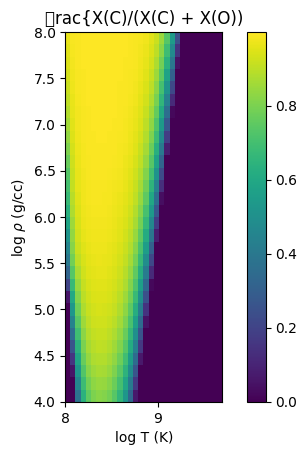

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(ratio.T, origin="lower",
               extent=[np.log10(Tmin), np.log10(Tmax),
                       np.log10(rhomin), np.log10(rhomax)])

fig.colorbar(im, ax=ax)

ax.set_xlabel("log T (K)")
ax.set_ylabel(r"log $\rho$ (g/cc)")
ax.set_title("\frac{X(C)/(X(C) + X(O))")